# "BUILDING TRADING DECISIONS USING GOOGLE TRENDS"
> "An introduction to pytrends using HD (homedepot) as reference stock"

- toc: true
- badges: true
- comments: true
- author: Sebastian Soran
- categories: [fastpages, jupyter, pytrends]

## Importing Libraries

In [8]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt

## Requesting Pytrends & Building Payload

In [10]:
pytrends = TrendReq(hl='en-US', tz=360)
#Building Payload
kw_list = ['homedepot']
pytrends.build_payload(kw_list, cat=0, timeframe='2022-01-10 2022-09-07', geo='US', gprop='')
interest_over_time_df = pytrends.interest_over_time()
del(interest_over_time_df['isPartial'])

In [11]:
#Reset index turning index of dates to first column
df = pd.DataFrame(interest_over_time_df)
df = df.reset_index(level=0)
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')
print(df)

          date  homedepot
0   2022-01-10         80
1   2022-01-11         83
2   2022-01-12         82
3   2022-01-13         77
4   2022-01-14         85
..         ...        ...
232 2022-08-30         44
233 2022-08-31         40
234 2022-09-01         42
235 2022-09-02         45
236 2022-09-03         41

[237 rows x 2 columns]


## Plotting Trends

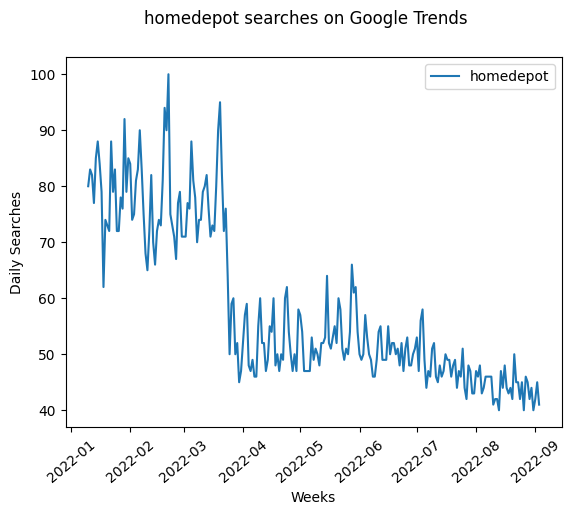

In [12]:
plt.plot( interest_over_time_df)
plt.suptitle(kw_list[0] + ' searches on Google Trends')
plt.xlabel('Weeks')
plt.xticks(rotation=40)
plt.ylabel('Daily Searches')
plt.legend(kw_list)
plt.show()

## Web-Scraping Stock Information

### Importing Libraries

In [14]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from selenium.webdriver.chrome.options import Options
# pip install webdriver-manager
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys, time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from openbb_terminal import api as openbb


### Loading Webdriver

In [31]:
s=Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service= s)

url = "https://www.investing.com/equities/home-depot-historical-data"
driver.get(url)
time.sleep(4)

#Dates
y1 = '2022'
d1 = '02'
m1 = '01'


load = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div/div/div[2]/main/div/div[7]/div/div/div[2]/div[2]/div[2]/div/div[1]')
load.click()
time.sleep(2.3)
element = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div/div/div[2]/main/div/div[7]/div/div/div[2]/div[2]/div[2]/div[2]/div[1]/div/div[1]/input')
time.sleep(2.3)
driver.execute_script("arguments[0].removeAttribute('readonly','readonly')",element)
element.send_keys(y1+m1+d1)
time.sleep(2.3)

##Submit Form
load_submit_button = driver.find_element(By.XPATH, ' //*[@id="__next"]/div/div/div/div[2]/main/div/div[7]/div/div/div[2]/div[2]/div[2]/div[2]/div[2]/button')
load_submit_button.click()
time.sleep(2.5)

##Setting up Dataframe
homedepot_date = []

stock_dates = driver.find_elements(By.XPATH, '//*[@id="__next"]/div/div/div/div[2]/main/div/div[7]/div/div/div[3]/div/table/tbody/tr/td[1]/time')

closing_price = driver.find_elements(By.XPATH, '//*[@id="__next"]/div/div/div/div[2]/main/div/div[7]/div/div/div[3]/div/table/tbody/tr/td[2]')

for i in range(len(closing_price)):
    dict_data = {'date': stock_dates[i].text,
                 'Closing': closing_price[i].text}
    homedepot_date.append(dict_data)
final = pd.DataFrame(homedepot_date)


#Resetting Index and Turning into Date-Time
final = final.reset_index(level = 0)
final['date'] = pd.to_datetime(final['date'])
final['Closing'] = final['Closing'].astype('float')
final = final.drop('index', axis = 1)

print(final)

          date  Closing
0   2022-09-07   294.13
1   2022-09-06   289.54
2   2022-09-02   291.90
3   2022-09-01   293.37
4   2022-08-31   288.42
..         ...      ...
166 2022-01-07   393.61
167 2022-01-06   405.76
168 2022-01-05   407.24
169 2022-01-04   412.84
170 2022-01-03   408.64

[171 rows x 2 columns]


In [32]:
#Merging and Partitioning Quarters

merged = pd.merge(df,final, how = 'inner')


q1 = pd.date_range(start = "01/01/2022",end = "03/31/2022")
q2 = pd.date_range(start = "04/01/2022",end = "06/30/2022")
q3 = pd.date_range(start = "07/01/2022",end = "09/30/2022")
q4 = pd.date_range(start = "10/01/2022",end = "12/31/2022")

quarterly_df =  []
for index, row in merged.iterrows():
    if q1.min() <= row["date"] <= q1.max():
        quarterly_df.append("Q1")
    elif q2.min() <= row["date"] <= q2.max():
        quarterly_df.append("Q2")
    elif q3.min() <= row["date"] <= q3.max():
        quarterly_df.append("Q3")
    else:
        quarterly_df.append("Q4")

merged['Quarters'] = quarterly_df

print(merged)

          date  homedepot  Closing Quarters
0   2022-01-10         80   387.46       Q1
1   2022-01-11         83   386.67       Q1
2   2022-01-12         82   389.40       Q1
3   2022-01-13         77   386.98       Q1
4   2022-01-14         85   372.00       Q1
..         ...        ...      ...      ...
159 2022-08-29         42   296.32       Q3
160 2022-08-30         44   293.10       Q3
161 2022-08-31         40   288.42       Q3
162 2022-09-01         42   293.37       Q3
163 2022-09-02         45   291.90       Q3

[164 rows x 4 columns]


In [34]:
##Add Volume to the time-series Dataframe

vol = openbb.stocks.load("hd", start_date= '2022-01-01')['Volume']
vol_final = vol.reset_index(level = 0)
vol_final
merged = pd.merge(merged,vol_final, how = 'inner')

merged.to_csv('new_merged.csv')

pd.read_csv('new_merged.csv')


Loading Daily HD stock with starting period 2022-01-03 for analysis.

,Unnamed: 0,date,homedepot,Closing,Quarters,Volume
0,0,2022-01-10,80,387.46,Q1,6440000
1,1,2022-01-11,83,386.67,Q1,4385400
2,2,2022-01-12,82,389.40,Q1,3623300
3,3,2022-01-13,77,386.98,Q1,3466300
4,4,2022-01-14,85,372.00,Q1,6336200
...,...,...,...,...,...,...
159,159,2022-08-29,42,296.32,Q3,2711800
160,160,2022-08-30,44,293.10,Q3,2892400
161,161,2022-08-31,40,288.42,Q3,4376200
162,162,2022-09-01,42,293.37,Q3,3742500
